# Parameter-Efficient Fine-Tuning.

In [ ]:
!pip install datasets
!pip install transformers[sentencepiece]
!pip install peft
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=234167a7950d9f2e32fbabfb0d21a4fc8f0fa6f87d1a93f283e0b7a9b84bbc32
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import transformers
import evaluate

import json
import numpy as np
import pandas as pd

import torch
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, T5ForConditionalGeneration

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, palette="Set2")

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset

from transformers import (
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator
)

from transformers import T5ForConditionalGeneration, T5Tokenizer

from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    TaskType
)

from peft import (
    get_peft_model,
    LoraConfig,
    PeftType,
)

from tqdm.auto import tqdm
from pathlib import Path

from sklearn.model_selection import train_test_split

## Описание задачи

Будем работать c моделью [ruT5](https://habr.com/ru/company/sberbank/blog/567776/) на данных новостей с портала [Газета.Ru](https://www.kaggle.com/datasets/phoenix120/gazeta-summaries) над задачей суммаризации новостей. Обычно при обсуждении задачи суммаризации выделяют два основных подхода:
* **Экстрактивная суммаризация.** В этом случае из исходного текста выделяются наиболее важные фрагменты, ключевые слова, которые и будут являться сжатым содержанием.
* **Абстрактивная суммаризация.** Этот подход отличается тем, что краткое содержание исходного текста порождается некоторой генеративной моделью.

Мы решаем задачу абстрактивной суммаризации. При решении задачи мы не будем обучать модель целиком, а попробуем применить некоторые подходы эффективного по параметрам обучения с помощью библиотеки [PEFT](https://github.com/huggingface/peft).

Надо оговориться, что идея применения T5-based архитектур для решения задач суммаризации на русском языке [не нова](https://sbercloud.ru/ru/datahub/rugpt3family/summarizer). Основной смысл задания состоит в том, чтобы реализовать полный пайплайна частичного обучения модели с помощью библиотеки `peft` и оценить получившееся качество.

Рассмотрим пример генерации с помощью `ruT5-base` для задачи денойзинга или заполнения слотов. Для инференса `transformers` предоставляет удобный метод `.generate(...)`. В зависимоcти от переданных параметров можно генерировать  с использованием жадной стратегии, сэмплирования с температурой, top-k или top-p сэмплирования, а также использовать beam search.

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
tokenizer = T5Tokenizer.from_pretrained("ai-forever/ruT5-base")

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
input_ids = tokenizer(
    "Снижение цен <extra_id_0> в Москве возможно только при <extra_id_1> " +
    "Это условие названо в аналитической заметке портала Новости <extra_id_2> ",
    return_tensors='pt'
)["input_ids"]

out_ids = model.generate(
    input_ids=input_ids,                 # послд-ть входных токенов, в нашем случае вход декодера
    max_length=64,                       # макс. длина ген. послед-ти
    eos_token_id=tokenizer.eos_token_id, # eos токен
    num_beams=5,                         # указываем num_beams - будет использован beam_search
)

tokenizer.decode(out_ids[0])

'<pad> <extra_id_0> на жилье <extra_id_1> соблюдении ряда условий. <extra_id_2> Москвы</s>'

Обратим внимание, что роль bos-токена играет `<pad>`. Далее, пропуски`<extra_id_X>` раскрываются в возможные фрагменты текста. В данном случае `<extra_id_0>`, `<extra_id_1>` и т.п. &mdash; это спец токены, которые которые модель должна заполнить, тем самым решая задачу денойзинга. Т.к. T5 &mdash; полноценный трансформер, на вход энкодера во время предобучения приходит текст с этими спец. токенами, а на вход декодера – те последовательности, что долны быть на месте спец. токенов.

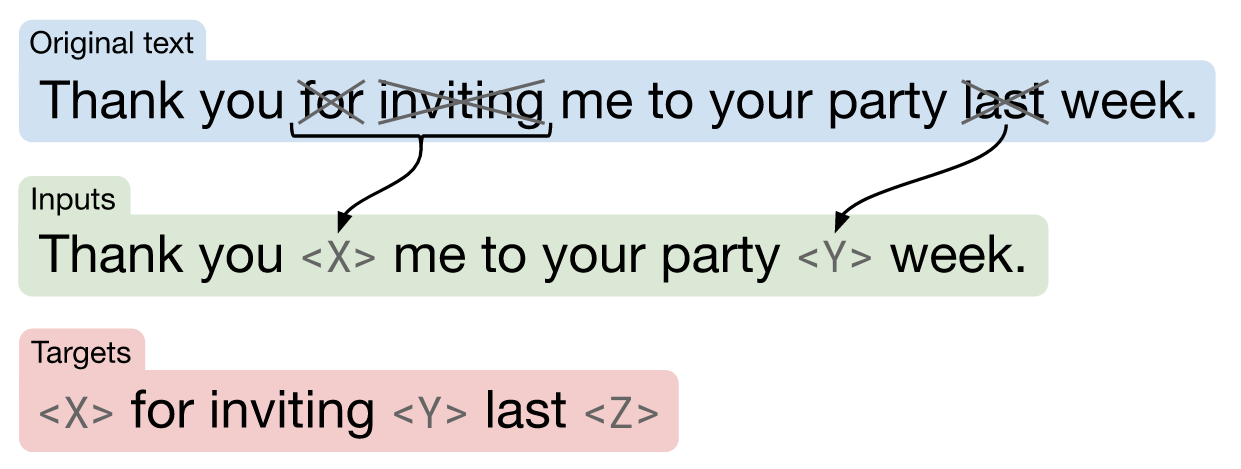

## Работа с данными

Теперь загрузим данные.

In [ ]:
dataset = load_dataset("IlyaGusev/gazeta", revision="v1.0", trust_remote_code=True)

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

gazeta_train.jsonl:   0%|          | 0.00/471M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Ограничим датасеты: тренировочный - 10к, валидация - 1к

In [ ]:
train_data = dataset["train"].select(range(10000))
val_data = dataset["validation"].select(range(1000))

Посмотрим, из чего состоит обучающий пример. Нас будут интересовать поля `text`, `summary`.

In [ ]:
train_data[13]

{'text': 'Российскому певцу Андрею Губину исполнилось 45 лет. Последнее время артист залег на дно и перестал радовать поклонников новыми хитами и полностью отказался от концертов. В одном из немногочисленных интервью, Губин жаловался на свое здоровье, указывая на проблемы нервной системы. По словам музыканта, врачи не уделили ему должного внимания, в связи с чем ему приходится бороться с проблемой самостоятельно. Продюсер «Ласкового мая» Андрей Разин рассказал о том, что он пытается помочь Губину. Разин подтвердил, что у звезды 90-х действительно серьезные проблемы, однако, по его мнению, это проблемы психического характера: «У Андрея серьезные проблемы с психикой. Ему мерещится, что у него постоянно чешется и болит лицо. Мы его водили по врачам, они ничего не нашли». Он также отметил, что с певцом стало очень тяжело говорить, поскольку тот стал чрезмерно вспыльчивым и ранимым, неадекватно воспринимая все попытки ему помочь, сообщает издание Bimru. По некоторой информации, покинув сцен

Выделим необходимые поля.

In [ ]:
train_text = [example['text'] for example in train_data]
train_summary = [example['summary'] for example in train_data]

val_text = [example['text'] for example in val_data]
val_summary = [example['summary'] for example in val_data]

Соберем датасеты.

In [ ]:
train_dataset = Dataset.from_dict({
    "text": train_text,
    "summary": train_summary
})

val_dataset = Dataset.from_dict({
    "text": val_text,
    "summary": val_summary
})

Напишем функцию для препроцессинга наших данных. Архитектурно модель `ruT5` &mdash; это полноценный трансформер. На вход модели будет поступать исходный текст новости, по которому она будет пытаться сгенерировать его сжатое саммари.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

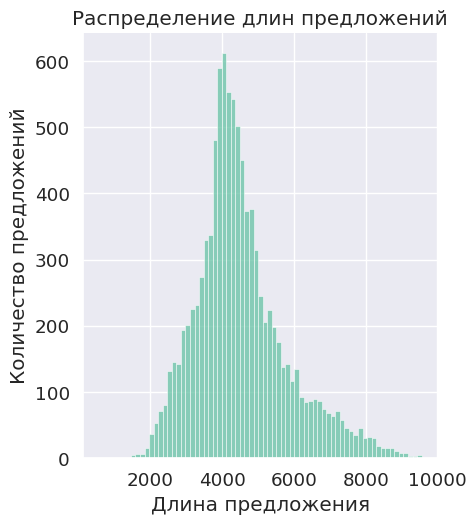

In [ ]:
lens = [len(x) for x in train_text]

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

Поставим границу на длине текстов равной 8к

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x500 with 0 Axes>

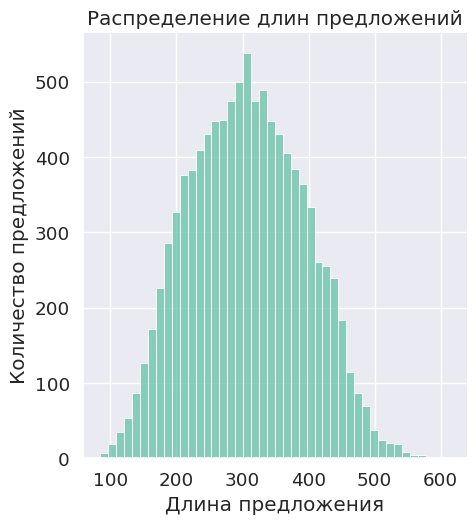

In [ ]:
lens = [len(x) for x in train_summary]

plt.figure(figsize=(15,5))

sns.displot(lens);
plt.xlabel("Длина предложения")
plt.ylabel("Количество предложений")
plt.title("Распределение длин предложений")

plt.show();

Ограничимся традиционной длиной 512

In [ ]:
def preprocess_function(examples):
    """ Функция препроцессинга для обработки данных. """

    # выделим input / targets для модели
    inputs = examples["text"]
    targets = examples["summary"]
    # токенизируем новости, это вход энкодера
    # наша source-последовательность
    model_inputs = tokenizer(inputs,
                             max_length=8000,
                             padding="max_length",
                             truncation=True,
                             return_tensors="pt")
    # токенизируем саммари, это входе декодера во время обучения
    # то есть наша target-последовательность
    labels = tokenizer(targets,
                       max_length=512,
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")
    # не будем считать лосс для паддинга
    # по умолчанию nn.CrossEntropy не учитыает в лоссе объекты с меткой -100
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    # сформируем вход для нашей модели
    model_inputs["labels"] = labels[0]
    model_inputs["input_ids"] = model_inputs["input_ids"][0]
    model_inputs["attention_mask"] = model_inputs["attention_mask"][0]
    return model_inputs

Применим препроцессинг к датасету. Обратим внимание, что паддинг мы сделали заранее. Понятно, что это не очень эффективно. При желании рекомендуется это исправить, то есть перенести паддинг на момент формирования батча в data collator. Заметим также, что саммари обычно гораздо меньше исходной новости, поэтому выставлять `max_length` следует аккуратно.

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    num_proc=2,
    desc="Running tokenizer on train dataset...",
)

val_dataset = val_dataset.map(
    preprocess_function,
    num_proc=2,
    desc="Running tokenizer on val dataset...",
)

Running tokenizer on train dataset... (num_proc=2):   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on val dataset... (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

## Обучение моделей

В библиотеке [`PEFT`](https://github.com/huggingface/peft) представлены различные подходы к эффективному по параметрам обучению. Рассмотрим некоторые из них.

### LoRA

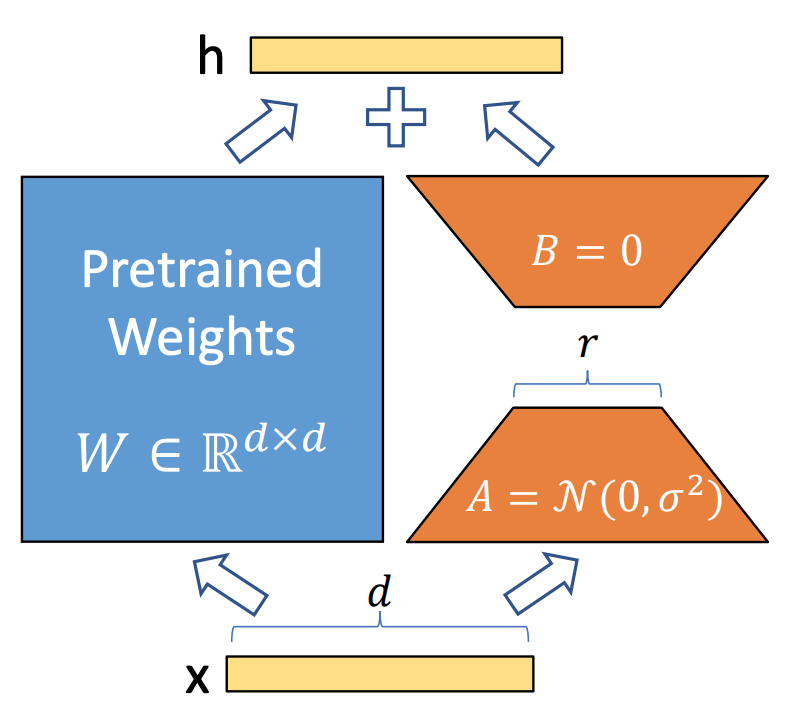

Позволяет повысить эффективность обучения посредством использования low-rank аппроксимации для матриц. Подробнее про метод и его использование можете прочитать [здесь](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora).

Реализуем LoRA-адаптер.

In [ ]:
class LoRALayerWrapper(nn.Module):
    def __init__(self, original_layer, rank=8, alpha=16):
        super().__init__()
        self.original_layer = original_layer
        self.original_layer.requires_grad_(False)

        in_features = original_layer.in_features
        out_features = original_layer.out_features

        self.lora_A = nn.Parameter(torch.empty(in_features, rank))
        self.lora_B = nn.Parameter(torch.empty(rank, out_features))
        self.scaling = alpha / rank

        nn.init.kaiming_uniform_(self.lora_A, a=5**0.5)  # Лучшая инициализация
        nn.init.zeros_(self.lora_B)

    def forward(self, x):
        return self.original_layer(x) + (x @ self.lora_A @ self.lora_B) * self.scaling

Проверим реализацию, сравнив ее с той, что предоставляет `peft`.

In [ ]:
torch.manual_seed(42)
rank = 4
alpha = 32
dummy_input = torch.randn(1, 1, 768)

# Реализация через peft
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    target_modules=["q", "v"],
    lora_dropout=0.0,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)

base_model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
peft_model = get_peft_model(base_model, peft_config)

In [ ]:
# возьмем один модуль для простого теста
q_layer_to_test = peft_model.base_model.encoder.block[0].layer[0].SelfAttention.q
# исходный линейный слой
base_linear_layer = q_layer_to_test.base_layer
# наша обертка
our_model = LoRALayerWrapper(base_linear_layer, rank=rank, alpha=alpha)

our_output = our_model(dummy_input)
peft_output = q_layer_to_test(dummy_input)
assert torch.allclose(our_output, peft_output, atol=1e-4), "Что-то не так с простым forward"

Тест выше совсем простой, т.к. из-за особенности инициализации изначально LoRA ничего не делает. Добавим чуть более сложный тест-кейс.

In [ ]:
dummy_B = torch.randn_like(our_model.lora_B.data)

with torch.no_grad():
    # скопируем параметры
    our_model.lora_B.data.copy_(dummy_B)
    q_layer_to_test.lora_B.default.weight.data.copy_(dummy_B.T)
    our_model.lora_A.data.copy_(q_layer_to_test.lora_A.default.weight.data.T)

# forward + backward pass для реализаций
our_output = our_model(dummy_input)
our_loss = our_output.sum()
our_loss.backward()

peft_output = q_layer_to_test(dummy_input)
peft_loss = peft_output.sum()
peft_loss.backward()

In [ ]:
our_grad_A = our_model.lora_A.grad
peft_grad_A = q_layer_to_test.lora_A.default.weight.grad.T

our_grad_B = our_model.lora_B.grad
peft_grad_B = q_layer_to_test.lora_B.default.weight.grad.T

assert torch.allclose(our_grad_A, peft_grad_A, atol=1e-4), "Расхождения градиентов для матрицы A"
assert torch.allclose(our_grad_B, peft_grad_B, atol=1e-4), "Расхождения градиентов для матрицы B"

Теперь напишем функцию для оборачивания модулей `q`, `v` через реализованный слой.

In [ ]:
def inject_lora(model, rank, alpha):
    # Энкодер
    for encoder_block in model.encoder.block:
        self_attn = encoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

    # Декодер
    for decoder_block in model.decoder.block:
        # Self attention
        self_attn = decoder_block.layer[0].SelfAttention
        self_attn.q = LoRALayerWrapper(self_attn.q, rank, alpha)
        self_attn.v = LoRALayerWrapper(self_attn.v, rank, alpha)

        # Cross attention
        cross_attn = decoder_block.layer[1].EncDecAttention
        cross_attn.q = LoRALayerWrapper(cross_attn.q, rank, alpha)
        cross_attn.v = LoRALayerWrapper(cross_attn.v, rank, alpha)

    # Замораживание параметров
    for name, param in model.named_parameters():
        if "lora_" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

In [ ]:
from transformers import T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained("ai-forever/ruT5-base")
model = inject_lora(model, rank=4, alpha=16)

In [ ]:
encoder_block = model.encoder.block[0]
self_attn = encoder_block.layer[0].SelfAttention
print(type(self_attn.q))
print(type(self_attn.v))

decoder_block = model.decoder.block[0]
self_attn = decoder_block.layer[0].SelfAttention
print(type(self_attn.q))

cross_attn = decoder_block.layer[1].EncDecAttention
print(type(cross_attn.q))

<class '__main__.LoRALayerWrapper'>
<class '__main__.LoRALayerWrapper'>
<class '__main__.LoRALayerWrapper'>
<class '__main__.LoRALayerWrapper'>


Доп проверка:

In [ ]:
# # Обучаемые параметры
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [ ]:
# # Убедимся, что оригинальные веса заморожены
# for name, param in model.named_parameters():
#     if "original_layer" in name:
#         print(name, param.requires_grad)

Отлично, теперь можно приступить к экспериментам.

In [ ]:
train_dataset

Dataset({
    features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 10000
})

In [ ]:
args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=1e-3,
    num_train_epochs=5,
    fp16=True,
    report_to="none",
)

from datasets import Dataset
train_data = Dataset.from_dict({"input_ids": train_dataset['input_ids'], "labels": train_dataset['labels']})

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
)

trainer.train()

## Оценка качества

Для оценки качества суммаризации можно использовать различные автоматические метрики:
* [BLEU](https://en.wikipedia.org/wiki/BLEU);
* [Rouge](https://en.wikipedia.org/wiki/ROUGE_(metric));
* [METEOR](https://en.wikipedia.org/wiki/METEOR);
* [chrF](https://huggingface.co/spaces/evaluate-metric/chrf).


В этом задании вам предлагается использовать метрику rouge, посчитать ее можно так:

In [ ]:
rouge = evaluate.load("rouge")
predictions = ["Предсказанный текст", "Еше один текст"]
references = ["Истинный текст", "Снова один текст"]

results = rouge.compute(predictions=predictions,
                        references=references,
                        tokenizer=lambda x: x.split())
print(results)

{'rouge1': 0.5833333333333333, 'rouge2': 0.25, 'rougeL': 0.5833333333333333, 'rougeLsum': 0.5833333333333333}


Не пугайтесь, если у вас получатся не нулевые, но плохие результаты.

In [ ]:
def evaluate_model(dataset, num_samples=None):
    predictions = []
    references = []

    if num_samples:
        dataset = dataset.select(range(num_samples))

    for example in tqdm(dataset, desc="Обработка примеров"):
        input_ids = tokenizer(
            example["text"],
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(device)

        output_ids = model.generate(
            input_ids,
            no_repeat_ngram_size=4,
            max_length=100,
            num_beams=5,
            early_stopping=True
        )

        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        reference = example["summary"]

        predictions.append(prediction)
        references.append(reference)

    results = rouge.compute(
        predictions=predictions,
        references=references,
        tokenizer=lambda x: x.split(),
    )

    return results

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

rouge = evaluate.load("rouge")

val_results = evaluate_model(val_dataset, num_samples=len(val_dataset))
print("Результаты оценки:")
print(f"ROUGE-1: {val_results['rouge1']:.4f}")
print(f"ROUGE-2: {val_results['rouge2']:.4f}")
print(f"ROUGE-L: {val_results['rougeL']:.4f}")

Обработка примеров:   0%|          | 0/1000 [00:00<?, ?it/s]

Результаты оценки:
ROUGE-1: 0.2623
ROUGE-2: 0.1144
ROUGE-L: 0.2088


Ура! получились ненулевые результаты

## Сравнение моделей

Загрузим [модель](https://huggingface.co/IlyaGusev/rut5_base_sum_gazeta), которая обучена на аналогичную задачу, и сравним ее с лучшей из ваших моделей на 2-3 примерах **реальных новостей**.

Скачаем модель с ссылки:

In [ ]:
model_name = "IlyaGusev/rut5_base_sum_gazeta"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_hf = T5ForConditionalGeneration.from_pretrained(model_name)

Возьмем две новости с яндекс новостей:

In [ ]:
sample_1 = 'В Щербинке обнаружили тела восьмилетнего мальчика и семилетней девочки в пруду.Известия Как сообщили в прокуратуре Москвы, на телах погибших не было признаков насильственной смерти.РЕН ТВ Установление всех обстоятельств и ход процессуальной проверки взяла на контроль прокуратура Троицкого и Новомосковского административных округов.Телеканал 360° На данный момент проводится процессуальная проверка, которая поможет выяснить все обстоятельства произошедшего.'
sample_1_true = 'В Щербинке в пруду обнаружили тела двух детей'

sample_2 = '''Владимир Путин и Дональд Трамп провели второй телефонный разговор, он продолжался более двух часов. Подробнее о том, к чему пришли президенты России и США, — в материале РБК
Дональд Трамп и Владимир Путин
Дональд Трамп и Владимир Путин
18 марта президенты России и США Владимир Путин и Дональд Трамп провели свой второй телефонный разговор. Он был посвящен урегулированию на Украине и состоялся через неделю после того, как в Джидде американская и украинская делегации договорились осуществить 30-дневное прекращение огня. В ответ Москва обозначила вопросы, которые должны быть прояснены перед установлением перемирия.

Разговор Путина и Трампа продлился около двух с половиной часов. После него стороны опубликовали сообщения, в которых изложили, о чем шла речь.

Что о разговоре сообщили Кремль и Белый дом
rbc.group
favicon
cloud.mail.ru
Перейти на сайт
По версии Кремля, Путин заявил о готовности вместе с США прорабатывать урегулирование на Украине, «которое должно носить комплексный, устойчивый и долгосрочный характер» и «учитывать безусловную необходимость устранения первопричин кризиса, законные интересы России в области безопасности». Он согласился на предложение Трампа о том, чтобы Россия и Украина на 30 дней отказались от ударов по объектам энергетической инфраструктуры, и «сразу дал российским военным соответствующую команду».


Путин и Трамп выразили обоюдный интерес в улучшении отношений
Политика
Дональд Трамп
Относительно общего 30-дневного перемирия российский президент обратил внимание на ряд следующих нюансов: контроль за прекращением огня по всей линии соприкосновения, остановка принудительной мобилизации на Украине и перевооружения ее вооруженных сил (ВСУ). Путин подчеркнул, что «для недопущения эскалации конфликта и работы в направлении его разрешения политико-дипломатическим путем» иностранные государства должны полностью прекратить передавать Киеву военную помощь и разведданные.

«Отмечены также серьезные риски, связанные с недоговороспособностью киевского режима, который уже неоднократно саботировал и нарушал достигнутые договоренности. Обращено внимание на варварские преступления террористического характера, совершенные украинскими боевиками против гражданского населения Курской области», — сообщил Кремль. Путин подтвердил, что, если украинские военные в Курской области сдадутся в плен, Россия гарантирует им «жизнь и достойное обращение согласно российским законам и нормам международного права». Российский президент сообщил, что 19 марта Москва и Киев обменяются пленными по формуле «175 на 175»; Россия также «в качестве жеста доброй воли» передаст Украине 23 тяжелораненых украинских военных.


Кремль рассказал об итогах переговоров Путина и Трампа
Политика
Владимир Путин
Путин также согласился с идеей «безопасности судоходства в акватории Черного моря» — президенты договорились начать переговоры, чтобы проработать детали такой инициативы. «Лидеры подтвердили намерение продолжить усилия по достижению украинского урегулирования в двустороннем режиме», — отмечает Кремль; для этого Россия и США создадут экспертные группы.

По сообщению Кремля, Путин и Трамп обсудили также ситуацию на Ближнем Востоке и в регионе Красного моря, о совместных усилиях по урегулированию кризисов и работе по ядерному нераспространению и ядерной безопасности. «Это, в свою очередь, будет способствовать оздоровлению общей атмосферы российско-американских отношений. Один из позитивных примеров — солидарное голосование в ООН по резолюции в отношении украинского конфликта, — сказано в сообщении Кремля. — Выражена обоюдная заинтересованность в нормализации двусторонних отношений в свете особой ответственности России и США за обеспечение безопасности и стабильности в мире». Также Трамп поддержал идею Путин организовать хоккейные матчи между российскими и американскими игроками, которые выступают в НХЛ и КХЛ.

Версию Белого дома опубликовала в соцсети X представитель администрации Кэролайн Левитт. «Оба лидера согласились, что этот конфликт должен закончиться прочным миром. Они также подчеркнули необходимость улучшения двусторонних отношений между Соединенными Штатами и Россией. Кровь и средства, которые Украина и Россия тратят на эту войну, лучше было бы потратить на нужды их народов», — сказано в сообщении. По словам Левитт, Трамп и Путин договорились начать движение к миру с прекращения огня по объектам энергетики и инфраструктуры, а также с «технических переговоров» по реализации прекращения огня в Черном море; переговоры об этом незамедлительно начнутся на Ближнем Востоке.

Белый дом также отметил, что Трамп и Путин сошлись в том, что «Иран никогда не должен быть в состоянии уничтожить Израиль». В целом, по оценке президентов, у американо-российских отношений есть большой потенциал — он включает крупные экономические сделки и геополитическую стабильность «по достижении мира».'
'''
sample_2_true = 'О чем Путин и Трамп договорились в ходе второго телефонного разговора Ранее США и Украина предложили ввести общее 30-дневное перемирие'

Учились на gpu - переведем модель на cpu:

In [ ]:
model.cpu()

T5ForConditionalGeneration(
  (shared): Embedding(30000, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(30000, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
article_text = sample_1

input_ids = tokenizer(
    [article_text],
    max_length=512,
    add_special_tokens=True,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

output_ids_hf = model_hf.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary)

summary_hf = tokenizer.decode(output_ids_hf, skip_special_tokens=True)
print(summary_hf)

print('Правильный ответ:', sample_1_true)

В Щербинке обнаружили тела восьмилетнего мальчика и семилетней девочки в пруду. Тела погибших не было признаков, на телах погибших нет признаков. Как сообщили в прокуратуре Москвы, тела погибших на телах не было, а на телах их не была признаков.
В Щербинке обнаружили тела восьмилетнего мальчика и семилетней девочки в пруду. Как сообщили в прокуратуре Москвы, на телах погибших не было признаков насильственной смерти. По данным прокуратуры Троицкого и Новомосковского административных округов, тела погибших были обнаружены не в пруду, а в пруду было нанесено насильственная смерть. Телеканал 360° На данный момент проводится процессуальная проверка, которая поможет выяснить все обстоятельства произошедшего.
Правильный ответ: В Щербинке в пруду обнаружили тела двух детей


In [ ]:
article_text = sample_2

input_ids = tokenizer(
    [article_text],
    max_length=512,
    add_special_tokens=True,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

output_ids_hf = model_hf.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary)

summary_hf = tokenizer.decode(output_ids_hf, skip_special_tokens=True)
print(summary_hf)

print('Правильный ответ:', sample_2_true)

Президенты России и США Владимир Путин и Дональд Трамп провели свой второй телефонный разговор, он продолжался более двух часов. Он был посвящен урегулированию на Украине и продолжался около двух часов. Подробности о том, к чему пришли российские и американские президенты, — в материале РБК.
Президенты России и США Владимир Путин и Дональд Трамп провели второй телефонный разговор, он продлился более двух часов. Об этом сообщили в Кремле и Белом доме. После разговора стороны опубликовали сообщения, в которых изложили, о чем шла речь.
Правильный ответ: О чем Путин и Трамп договорились в ходе второго телефонного разговора Ранее США и Украина предложили ввести общее 30-дневное перемирие


**Вывод:**

* Обучили модель суммаризации новостей в заголовки

* При обучении мы использовали и реализовали PEFT метод - метод добавления специальных блоков для дообучения только их

* Провалидировали модель с помощью Rouge метрики - и даже получились ненулевые значения метрики!!!

* Модель с HF выдает более расширенные,точные и понятные ответы, чем нами обученная, однако обе модели довольно далеки от короткого правильного ответа, но возможно это какие-то особенности Яндекс новостей - короткие описания, так как обе модели обучались на одном датасете